In [ ]:
# hide
import sys
sys.path.append("..")
%load_ext autoreload
%autoreload 2

# Motion classification with time series using deep learning

> Classify between chaotic, rotational and librational motion using the evolution of the coordinates x and y in the Poincare map

## Notebook parameters 
Put here everything that could be needed if this notebook was called from outside, as an script

In [ ]:
use_wandb = False # Whether to use or not wandb for experiment tracking
wandb_group = None # Whether to group this run in a wandb group
resampling_period = None # * Natural number. Set to None if no resampling is desired
labelling_method = "fli" # [fli, freq_ana]

## Requirements

In [ ]:
import sys
ISCOLAB = 'google.colab' in sys.modules
if ISCOLAB:
    !pip install git+https://github.com/fastai/fastcore.git@master -q
    !pip install git+https://github.com/fastai/fastai2.git@master -q
    !pip install git+https://github.com/ai-fast-track/timeseries.git -q
    !pip install wandb -q

In [ ]:
from fastai2.basics import *
from timeseries.all import *
from mlchaos.all import *
import wandb
from fastai2.callback.wandb import *

In [ ]:
base_path = Path.home()

In [ ]:
if not use_wandb:
    os.environ['WANDB_MODE'] = 'dryrun' # run offline
    wandb.init(anonymous='allow', allow_val_change=True)
else:
    os.environ['WANDB_MODE'] = 'run' # run offline
    wandb.init(project='mlchaos', group=wandb_group)

wandb: Wandb version 0.10.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## Loading the data

The data must be loaded as a `TSDataChaos` object, created from a pair (or a sequence of pairs) of files:
1. The first file of the pair contains the data of the Poincare map
2. The second file of the pair contains the index of the motion (0.0, 1.0 or 2.0). The column that contains the index is given as a parameter of this notebook

Depending on the labelling method, a different column from the index file will be used as `y` on the data. `x` will always be the time series.

In [ ]:
wandb.config.labelling_method = labelling_method
index_cols = {
    "fli": 7,
    "freq_ana": 8
}

wandb: Wandb version 0.10.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [ ]:
ds_path = base_path/'data/fli_rotnum/model_1'
fnames = [
    (ds_path/'eps=0.021/Poincare.plt', ds_path/'eps=0.021/index_fli_freqana.plt'),
    (ds_path/'eps=0.022/Poincare.plt', ds_path/'eps=0.022/index_fli_freqana.plt'), 
    (ds_path/'eps=0.023/Poincare.plt', ds_path/'eps=0.023/index_fli_freqana.plt'), 
    (ds_path/'eps=0.024/Poincare.plt', ds_path/'eps=0.024/index_fli_freqana.plt'), 
    (ds_path/'eps=0.025/Poincare.plt', ds_path/'eps=0.025/index_fli_freqana.plt'), 
]
wandb.config.fnames = fnames
data = TSDataChaos.from_poincare_and_index_files(fnames, 
                                                 index_col=index_cols[labelling_method])
data

wandb: Wandb version 0.10.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


TSDataChaos:
 Datasets names (concatenated): ['eps=0.021', 'eps=0.022', 'eps=0.023', 'eps=0.024', 'eps=0.025']
 Filenames:                     [(Path('/home/user/data/fli_rotnum/model_1/eps=0.021/Poincare.plt'), Path('/home/user/data/fli_rotnum/model_1/eps=0.021/index_fli_freqana.plt')), (Path('/home/user/data/fli_rotnum/model_1/eps=0.022/Poincare.plt'), Path('/home/user/data/fli_rotnum/model_1/eps=0.022/index_fli_freqana.plt')), (Path('/home/user/data/fli_rotnum/model_1/eps=0.023/Poincare.plt'), Path('/home/user/data/fli_rotnum/model_1/eps=0.023/index_fli_freqana.plt')), (Path('/home/user/data/fli_rotnum/model_1/eps=0.024/Poincare.plt'), Path('/home/user/data/fli_rotnum/model_1/eps=0.024/index_fli_freqana.plt')), (Path('/home/user/data/fli_rotnum/model_1/eps=0.025/Poincare.plt'), Path('/home/user/data/fli_rotnum/model_1/eps=0.025/index_fli_freqana.plt'))]
 Data shape: (51005, 2, 201)
 Targets shape: (51005,)
 Nb Samples: 51005
 Nb Channels:           2
 Sequence Length: 201

Check the distribution of classes in the dataset

In [ ]:
np.unique(data.y, return_counts=True)

(array([-1.,  0.,  1.,  2.]), array([ 3990,  3800, 25444, 17771]))

The class -1 represents uncertainty in the FLI-based classication. If desired, we can remove that class from the dataset, by changing the flag `add_uncertainty_class` in the cell below. 

In [ ]:
wandb.config.add_uncertainty_class = False

wandb: Wandb version 0.10.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [ ]:
if not wandb.config.add_uncertainty_class:
    data.x = data.x[data.y != -1]
    data.y = data.y[data.y != -1]
data

TSDataChaos:
 Datasets names (concatenated): ['eps=0.021', 'eps=0.022', 'eps=0.023', 'eps=0.024', 'eps=0.025']
 Filenames:                     [(Path('/home/user/data/fli_rotnum/model_1/eps=0.021/Poincare.plt'), Path('/home/user/data/fli_rotnum/model_1/eps=0.021/index_fli_freqana.plt')), (Path('/home/user/data/fli_rotnum/model_1/eps=0.022/Poincare.plt'), Path('/home/user/data/fli_rotnum/model_1/eps=0.022/index_fli_freqana.plt')), (Path('/home/user/data/fli_rotnum/model_1/eps=0.023/Poincare.plt'), Path('/home/user/data/fli_rotnum/model_1/eps=0.023/index_fli_freqana.plt')), (Path('/home/user/data/fli_rotnum/model_1/eps=0.024/Poincare.plt'), Path('/home/user/data/fli_rotnum/model_1/eps=0.024/index_fli_freqana.plt')), (Path('/home/user/data/fli_rotnum/model_1/eps=0.025/Poincare.plt'), Path('/home/user/data/fli_rotnum/model_1/eps=0.025/index_fli_freqana.plt'))]
 Data shape: (47015, 2, 201)
 Targets shape: (47015,)
 Nb Samples: 47015
 Nb Channels:           2
 Sequence Length: 201

The data can be resampled to a lower frequency if desired. The reason why this is interesting is because being able to produce an accurate classification without the need of many data points per time series makes this procedure applicable to observational data. As an example, choosing `resampling_period` equals to 2 means that the time series will be resampled in a way that we take one point every 2 points of the original data.  

In [ ]:
wandb.config.resampling_period = resampling_period

wandb: Wandb version 0.10.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [ ]:
if wandb.config.resampling_period is not None:
    data.x = data.x[:,:,::wandb.config.resampling_period]
    print(data)

We'll use a dictionary to establish how to label each index to an actual human-readable label

In [ ]:
lbl_dict = dict([
    ('-1.0', 'uncertain'),
    ('0.0', 'chaotic'),   
    ('1.0', 'rotational'),   
    ('2.0', 'librational')]
)

## Splitting the data into training and validation

One easy option to split data is to use 80% random items from the data as training and 20% as validation

In [ ]:
splits = RandomSplitter()(range_of(data.get_items()))
#splits = (range_of(data.get_items()), range_of(data.get_items())) # Valid = train

Another way to split the data, which is more sensible if we want to ensure that the knowledge in the model can be transferred to unknown dynamic models, is to ensure that motions in the validation set are not included in the training set. We can do this by ensuring that the motions of the validation set belong to a specific dynamic model, and the rest of dynamics will be used for training

In [ ]:
val_dataset = 'eps=0.023'

In [ ]:
val_idxs = np.where(data.ds == data.dsname.index(val_dataset))[0]
val_idxs

array([20402, 20403, 20404, ..., 30600, 30601, 30602])

In [ ]:
splits = IndexSplitter(val_idxs)(data.get_items())
splits

((#36814) [0,1,2,3,4,5,6,7,8,9...],
 (#10201) [20402,20403,20404,20405,20406,20407,20408,20409,20410,20411...])

##  Creating a `Datasets` object

In [ ]:
tfms = [[ItemGetter(0), ToTensorTS(), ToTensorMotion()], # x transforms
        [ItemGetter(1), lbl_dict.get, Categorize()]] # y transforms

In [ ]:
%%time
ds = Datasets(items=data.get_items(), tfms=tfms, splits=splits)

CPU times: user 4.06 s, sys: 6.69 ms, total: 4.07 s
Wall time: 4.06 s


Show one element of the dataset. By default, the `show` method will display the item as a Poincare map.

rotational


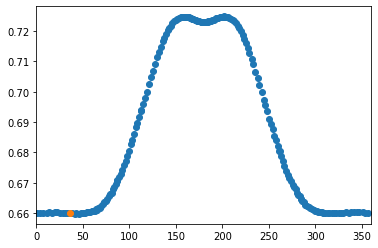

In [ ]:
ax = show_at(ds, 1003, figsize=(1,1))

It can be useful to visualize the motions with he same y limits. We take them from the training set

In [ ]:
ylim = [data.x[:, 1].min(), data.x[:, 1].max()]
ylim

[-0.621060974808266, 1.62106097480744]

rotational


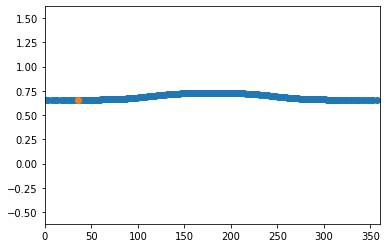

In [ ]:
ax = show_at(ds, 1003, figsize=(1,1), ylim=ylim)

## Creating a `Dataloaders` object

In [ ]:
bs = 256                            
# Normalize at batch time
tfm_norm = Standardize(scale_subtype = 'per_sample')
batch_tfms = []

dls = ds.dataloaders(bs=bs, val_bs=bs * 2, after_batch=batch_tfms, num_workers=0, device=default_device()) 

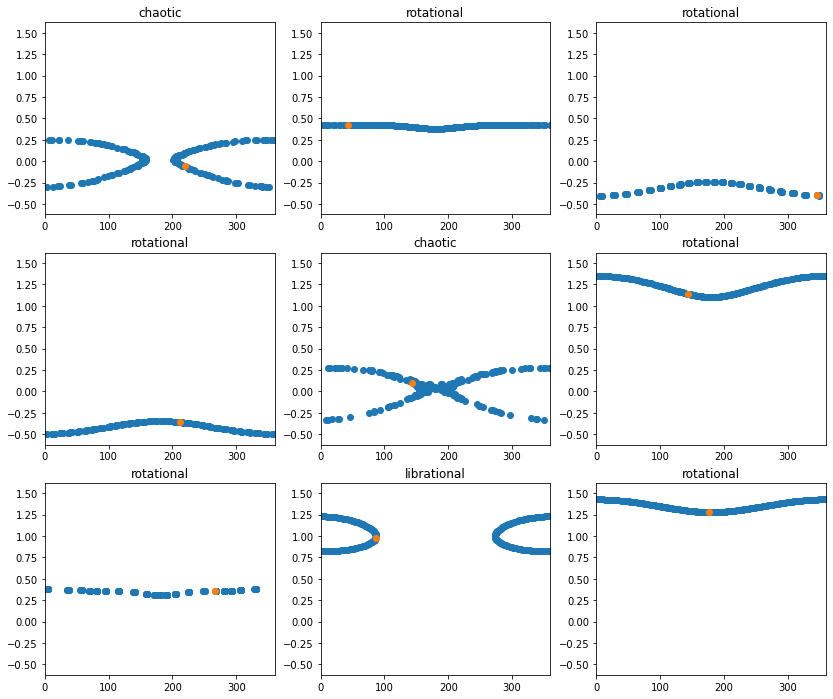

In [ ]:
dls.show_batch(max_n=9, ylim=ylim, return_fig=False)

In [ ]:
xb, yb = dls.one_batch()
print(xb[0].mean(axis=1), xb[0].std(axis=1))

tensor([181.4051,   0.5582], device='cuda:0') tensor([9.6324e+01, 1.3068e-02], device='cuda:0')


## Training a model 

In [ ]:
# Number of channels
c_in = get_n_channels(dls.train) # data.n_channels
# Number of classes
c_out= dls.c 
c_in,c_out

(2, 3)

In [ ]:
model = inception_time(c_in, c_out).to(device=default_device())
# model

### Creating a Learner object

In [ ]:
# opt_func = partial(Adam, lr=3e-3, wd=0.01)
#Or use Ranger
def opt_func(p, lr=slice(3e-3)): return Lookahead(RAdam(p, lr=lr, mom=0.95, wd=0.01)) 

In [ ]:
#Learner    
loss_func = LabelSmoothingCrossEntropy() 
learn = Learner(dls, model, opt_func=opt_func, 
                loss_func=loss_func, metrics=accuracy)

# print(learn.summary())

(0.017378008365631102, 0.00015848931798245758)

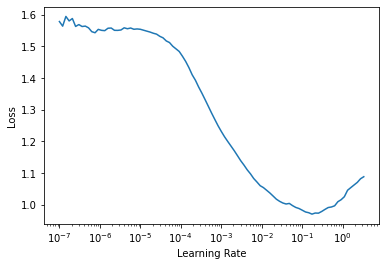

In [ ]:
lr_min, lr_steep = learn.lr_find()
lr_min, lr_steep

In [ ]:
learn.fit_one_cycle(10, lr_max=3e-3, cbs=WandbCallback(log_preds=False))
learn.recorder.plot_loss()

wandb: Wandb version 0.10.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


epoch,train_loss,valid_loss,accuracy,time
0,0.512474,0.458980,0.912754,00:38


/usr/local/lib/python3.6/dist-packages/fastai2/callback/schedule.py:68: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx = (pos >= pcts).nonzero().max()


## Showing results

### Results for random items in the validation set 

In [ ]:
learn.show_results(max_n=9, ylim=ylim)

### Showing the confusion matrix

In [ ]:
interp = ClassificationInterpretationAugmented.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,8))

### Smallest errors

In [ ]:
interp.plot_top_losses(k=9, figsize=(15, 15), largest=False)

### Largest errores

In [ ]:
interp.plot_top_losses(k=15, figsize=(15, 15), nrows=5, largest=True, ylim=ylim)

## Types of errors

It is also interesting to display separately errors of different type. There are a number of `c*(c-1)` possible type of errors, where `c` is the number of classes in the data

In [ ]:
print(interp.top_losses(k=3, largest=False, predicted='chaotic', actual='chaotic'))
print(interp.top_losses(k=3, largest=False, predicted='rotational', actual='rotational'))
print(interp.top_losses(k=3, largest=False, predicted='librational', actual='librational'))

In [ ]:
predicted = 'chaotic'
actual = 'chaotic'
n_errors = interp.confusion_matrix()[interp.vocab.o2i[predicted], 
                                     interp.vocab.o2i[actual]]
interp.plot_top_losses(k=min(n_errors, 9), figsize=(15, 15), 
                       largest=False, ylim=ylim, 
                       predicted=predicted, 
                       actual=actual)

## Explaining the model predictions through class activation maps

We will use the function `show_cam` from the library `timeseries` to plot the Class Activation Maps (CAMs)

In [ ]:
?show_cam

We need a function `i2o` that, given an encoded y, i.e, an instance of `TensorCategory`, return the label associated to that index, i.e., we need to decode the labels.

In [ ]:
def i2o(y):
    return dls.tfms[1].decode(y)

In [ ]:
print(i2o(TensorCategory(0)))
print(i2o(TensorCategory(1)))
print(i2o(TensorCategory(2)))

## Inference on a new test set

Now let's see how the trained behaves with a completely unseen set of data. First we have to load the Poincare maps that comprise the test set

Compute the predicted labels using the library `fastinference`. It is faster than the original `fastai` implementation.

In [ ]:
#old_get_preds = learn.get_preds
#from fastinference.inference import *

In [ ]:
test_base_path = base_path/'data/eps=0.02_pert_pend_model_2'

In [ ]:
fnames_test = (test_base_path/'Poincare200pt.plt', 
               test_base_path/'index200pt.plt')
test_data = TSDataChaos.from_poincare_and_index_files(fnames_test)
test_data

In [ ]:
if not wandb.config.add_uncertainty_class:
    test_data.x = test_data.x[test_data.y != -1]
    test_data.y = test_data.y[test_data.y != -1]
test_data

Create a dataloader from the test items previously loaded. This will apply all the transformations used in our training and validation set (e.g. normalization) to the test data

In [ ]:
test_dl = learn.dls.test_dl(test_data.get_items(), with_labels=True)
test_dl.n

In [ ]:
preds, targs, preds_decoded = learn.get_preds(dl=test_dl, with_decoded=True)
preds.__len__()

Compute metrics (validation loss and accuracy) on the test set.

In [ ]:
test_metrics = learn.validate(dl=test_dl)
test_metrics

Show also trhe confusion matrix for this test set

In [ ]:
# learn.get_preds = old_get_preds
interp_test = ClassificationInterpretationAugmented.from_learner(learn, 
                                                                 dl=test_dl)

In [ ]:
interp_test.plot_confusion_matrix(
    title=f'Confusion matrix (accuracy={round(test_metrics[1], 2)})',
)
plt.savefig(test_base_path/f'confusion_matrix_{test_base_path.name}.png')

Show the FLI plot to get a sense of the quality of the predictions

In [ ]:
ml_map = show_fli_plot(test_data.x, 
                    [dls.tfms[1].decode(y) for y in preds_decoded], 
                    legend=None,
                    palette=dict(
                        chaotic='yellow', 
                        librational='blue', 
                        rotational='magenta'))

In [ ]:
ml_map.figure.savefig(test_base_path/f'ml_map_{test_base_path.name}.eps', 
                      transparent=True, format='.eps')

Now show the same plot for the true labels given by the FLI-based classification

In [ ]:
true_map = show_fli_plot(test_data.x, 
                    [dls.tfms[1].decode(y) for y in targs], 
                    legend=None,
                    palette=dict(
                        chaotic='yellow', 
                        librational='blue', 
                        rotational='magenta'))

In [ ]:
true_map.figure.savefig(test_base_path/f'true_map_{test_base_path.name}.eps', 
                        transparent=True, format='.eps')